### imports

In [1]:
from utils import lmo_fro, lmo_spectral, prox_l1, grad_gb, prox_mcp, spectral_prox_l1
from BCD import load_dataset, Hadamard_BCD

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

from tqdm import tqdm

from problems import generateWH, run_MoreauNSD, run_VS

## Run algorithms

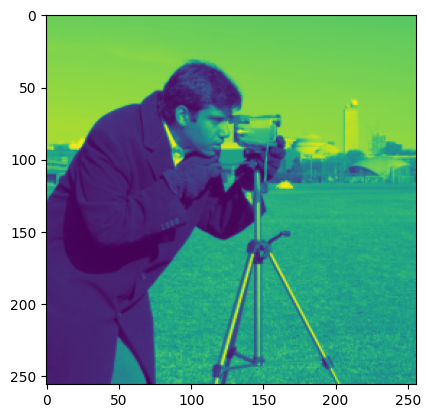

(256, 256)


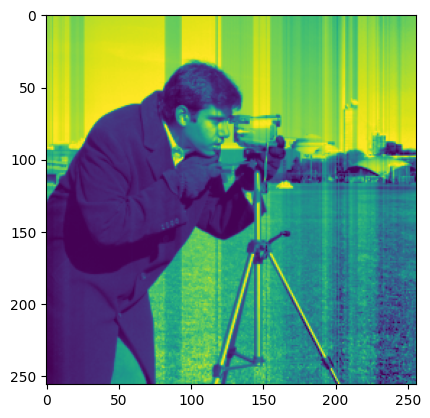

In [51]:
# D = load_dataset("synthetic", m = 250, n = 250)
D = load_dataset("olivetti").T
D = load_dataset("camera")
# D = load_dataset("spectrometer")
# D = load_dataset("football")
# D = load_dataset("miserables")
# D = load_dataset("low_rank_synthetic")
# from scipy.linalg import svd
plt.imshow(D)
plt.show()

# Min-Max Scaling
# Apply to each column (axis=0)
min_vals = D.min(axis=0)
max_vals = D.max(axis=0)

D = (D - min_vals) / (max_vals - min_vals)
plt.imshow(D)
print(D.shape)

In [57]:
rank = 20
# m = 200
# n = 1000
# W1, H1, W2, H2, error, times = Hadamard_BCD(D, r=rank, maxiter= 10)

# W = W1*W2
# H = H1*H2
# W, H = generateWH(m, n, rank)
# D = W@H
# plt.imshow(D)
# F_min = np.linalg.norm(W, 1)
def g(W):
    s = svd(W, compute_uv=False)
    # S = np.zeros((m,rank))
    # for i in range(len(s)):
    #     S[i, i] = np.abs(s[i])
    return np.sum(np.abs(s))# U@S@Vt


print(D.shape)
norm_D = np.linalg.norm(D, 'fro')**2
print(norm_D)
# D /= norm_D

F_min = g(D)
K = 5_000

prox = spectral_prox_l1
# prox = prox_l1


loss_NSD, dist_W_prox_NSD, WHs_NSD = run_MoreauNSD(D, rank, prox, max_iter = K)

# plt.scatter(np.arange(len(loss))[::50], loss[::50]/norm_D, label = 'Spectral lmo', marker="v")

# loss = run_MoreauNSD(D, 10, lmo = lmo_fro)
# plt.semilogy(loss/norm_D, label = 'l2 lmo')

loss_VS, dist_W_prox_VS, WHs_VS = run_VS(D, rank, prox, max_iter = K)


(256, 256)
23355.2082844017


100%|██████████| 5000/5000 [00:03<00:00, 1551.98it/s]


Text(0.5, 1.0, 'VS')

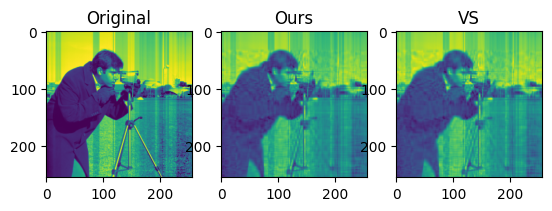

In [58]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(D)
ax[0].set_title('Original')

W, H = WHs_NSD[-1]
ax[1].imshow(norm_D*W@H)
ax[1].set_title('Ours')

W, H = WHs_VS[-1]
ax[2].imshow(W@H)
ax[2].set_title('VS')


## Plots

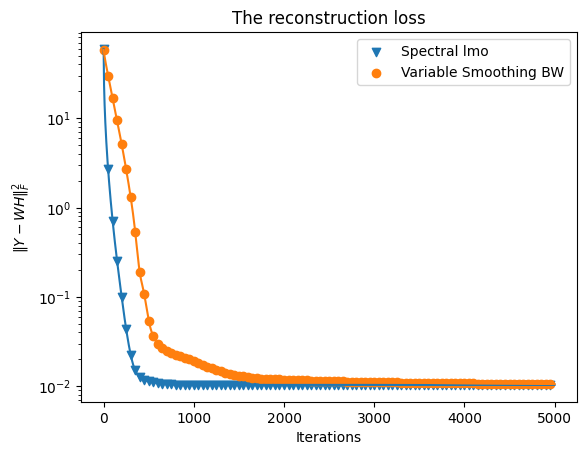

In [59]:
plt.semilogy(loss_NSD/norm_D)
plt.scatter(np.arange(len(loss_NSD))[::50], loss_NSD[::50]/norm_D, label = 'Spectral lmo', marker="v")

plt.semilogy(loss_VS/norm_D)
plt.scatter(np.arange(len(loss_VS))[::50], loss_VS[::50]/norm_D, label = 'Variable Smoothing BW', marker="o")

# plt.semilogy(loss/norm_D)
# plt.scatter(np.arange(len(loss))[::50], loss[::50]/norm_D, label = 'Spectral lmo', marker="v")
# plt.semilogy(loss/norm_D)
# plt.scatter(np.arange(len(loss))[::50], loss[::50]/norm_D, label = 'Spectral lmo', marker="v")
# W1, H1, W2, H2, error, times = Hadamard_BCD(D, r=rank, maxiter= K)
# print(len(error))
# plt.semilogy(error)
# plt.scatter(np.arange(len(error))[::50], error[::50], label = 'BCD', marker="^")

plt.ylabel(r'$\|Y - WH\|_F^2$')
plt.xlabel('Iterations')
plt.title('The reconstruction loss')

plt.legend()
plt.show()
    

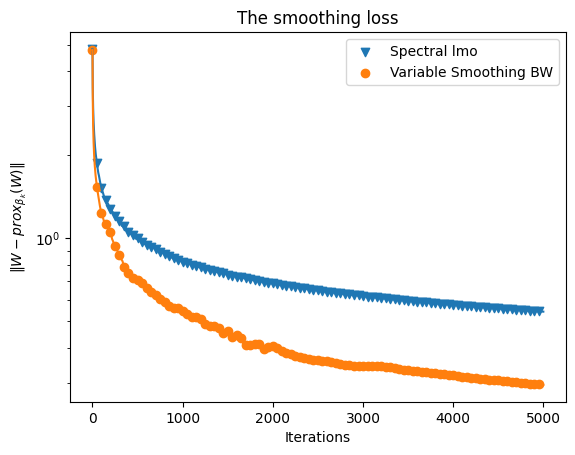

In [60]:
plt.semilogy(dist_W_prox_NSD)
plt.scatter(np.arange(len(dist_W_prox_NSD))[::50], dist_W_prox_NSD[::50], label = 'Spectral lmo', marker="v")

plt.semilogy(dist_W_prox_VS)
plt.scatter(np.arange(len(dist_W_prox_VS))[::50], dist_W_prox_VS[::50], label = 'Variable Smoothing BW', marker="o")


plt.ylabel(r'$\|W - prox_{\beta_k}(W)\|$')
plt.xlabel('Iterations')
plt.title('The smoothing loss')

plt.legend()
plt.show()

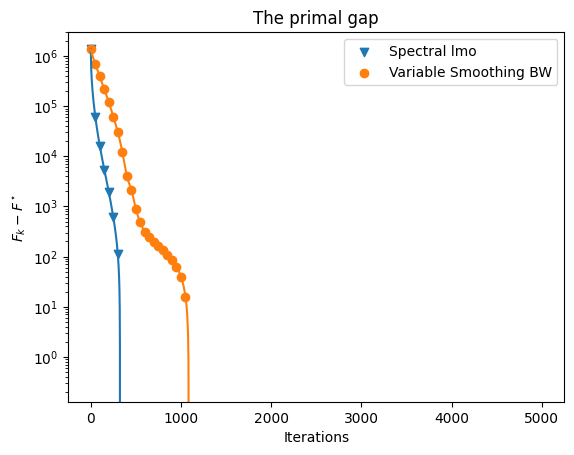

In [61]:
ls_NSD = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_NSD):
    ls_NSD[i] = np.linalg.norm(D - W@H, 'fro')**2 + g(W) - F_min
plt.semilogy(ls_NSD)
plt.scatter(np.arange(len(ls_NSD))[::50], ls_NSD[::50], label = 'Spectral lmo', marker="v")

ls_VS = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_VS):
    ls_VS[i] = np.linalg.norm(D - W@H, 'fro')**2 + g(W) - F_min
plt.semilogy(ls_VS)
plt.scatter(np.arange(len(ls_VS))[::50], ls_VS[::50], label = 'Variable Smoothing BW', marker="o")

plt.ylabel(r'$F_k - F^\star$')
plt.xlabel('Iterations')
plt.title('The primal gap')

plt.legend()
plt.show()
    